In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy import random

#load data
countries = pd.read_csv('../data/processed/countries.csv')
matches = pd.read_csv('../data/processed/matches.csv')
leagues = pd.read_csv('../data/processed/leagues.csv')
teams = pd.read_csv('../data/processed/teams.csv')
#matches.dropna(inplace=True)
countries.head()

,id,name
0,1,Belgium
1,1729,England
2,4769,France
3,7809,Germany
4,10257,Italy


In [2]:
matches.head()

,league_id,season,date,home_team_api_id,away_team_api_id,B365H,B365D,B365A,Date,HomeTeam,AwayTeam
0,1,2008/2009,2008-08-17 00:00:00,9987,9993,1.73,3.40,5.00,NaN,NaN,NaN
1,1,2008/2009,2008-08-16 00:00:00,10000,9994,1.95,3.20,3.60,NaN,NaN,NaN
2,1,2008/2009,2008-08-16 00:00:00,9984,8635,2.38,3.30,2.75,NaN,NaN,NaN
3,1,2008/2009,2008-08-17 00:00:00,9991,9998,1.44,3.75,7.50,NaN,NaN,NaN
4,1,2008/2009,2008-08-16 00:00:00,7947,9985,5.00,3.50,1.65,NaN,NaN,NaN


In [3]:
matches.tail()

,league_id,season,date,home_team_api_id,away_team_api_id,B365H,B365D,B365A,Date,HomeTeam,AwayTeam
33177,21518,2019/2020,NaN,7878,8315,2.00,3.50,3.40,2020-07-19,Granada,Ath Bilbao
33178,21518,2019/2020,NaN,0,8633,2.62,3.80,2.35,2020-07-19,Leganes,Real Madrid
33179,21518,2019/2020,NaN,8581,8305,5.00,3.80,1.66,2020-07-19,Levante,Getafe
33180,21518,2019/2020,NaN,8371,8661,1.75,3.75,4.20,2020-07-19,Osasuna,Mallorca
33181,21518,2019/2020,NaN,8302,10267,1.90,3.40,4.00,2020-07-19,Sevilla,Valencia


In [4]:
leagues.head()

,id,country_id,name
0,1,1,Belgium Jupiler League
1,1729,1729,England Premier League
2,4769,4769,France Ligue 1
3,7809,7809,Germany 1. Bundesliga
4,10257,10257,Italy Serie A


In [5]:
teams.head()

,team_api_id,team_long_name
0,9987,KRC Genk
1,9993,Beerschot AC
2,10000,SV Zulte-Waregem
3,9994,Sporting Lokeren
4,9984,KSV Cercle Brugge


In [6]:
#select relevant countries and merge with leagues
selected_countries = ['England','France','Germany','Italy','Spain']
countries = countries[countries.name.isin(selected_countries)]
leagues = countries.merge(leagues,on='id',suffixes=('', '_y'))

In [7]:
#select relevant fields
matches = matches[matches.league_id.isin(leagues.id)]
matches = matches[['league_id', 'season', 'date', 'home_team_api_id', 'away_team_api_id', 'B365H', 'B365D' ,'B365A']]
matches['League'] = matches.league_id.map(leagues.set_index('id')['name_y'])
matches.head()

,league_id,season,date,home_team_api_id,away_team_api_id,B365H,B365D,B365A,League
1728,1729,2008/2009,2008-08-17 00:00:00,10260,10261,1.29,5.5,11.00,England Premier League
1729,1729,2008/2009,2008-08-16 00:00:00,9825,8659,1.20,6.5,15.00,England Premier League
1730,1729,2008/2009,2008-08-16 00:00:00,8472,8650,5.50,3.6,1.67,England Premier League
1731,1729,2008/2009,2008-08-16 00:00:00,8654,8528,1.91,3.4,4.20,England Premier League
1732,1729,2008/2009,2008-08-17 00:00:00,10252,8456,1.91,3.4,4.33,England Premier League


In [8]:
from scipy.stats import entropy

def match_entropy(row):
    odds = [row['B365H'],row['B365D'],row['B365A']]
    #change odds to probability
    probs = [1/o for o in odds]
    #normalize to sum to 1
    norm = sum(probs)
    probs = [p/norm for p in probs]
    return entropy(probs)

#compute match entropy
matches['entropy'] = matches.apply(match_entropy,axis=1)
matches.head()

,league_id,season,date,home_team_api_id,away_team_api_id,B365H,B365D,B365A,League,entropy
1728,1729,2008/2009,2008-08-17 00:00:00,10260,10261,1.29,5.5,11.00,England Premier League,0.738980
1729,1729,2008/2009,2008-08-16 00:00:00,9825,8659,1.20,6.5,15.00,England Premier League,0.641186
1730,1729,2008/2009,2008-08-16 00:00:00,8472,8650,5.50,3.6,1.67,England Premier League,0.975928
1731,1729,2008/2009,2008-08-16 00:00:00,8654,8528,1.91,3.4,4.20,England Premier League,1.039730
1732,1729,2008/2009,2008-08-17 00:00:00,10252,8456,1.91,3.4,4.33,England Premier League,1.036584


In [9]:
#compute mean entropy for every league in every season
entropy_means = matches.groupby(['season','League']).entropy.mean()
entropy_means = entropy_means.reset_index().pivot(index='season', columns='League', values='entropy')
entropy_means.head(12)

League,England Premier League,France Ligue 1,Germany 1. Bundesliga,Italy Serie A,Spain LIGA BBVA
season,,,,,
2008/2009,0.984556,1.026638,1.004276,1.002201,1.010859
2009/2010,0.956496,1.013821,0.997925,1.006755,0.977810
2010/2011,0.983258,1.026236,1.016264,1.006029,0.975032
2011/2012,0.969593,1.024915,1.001298,1.003077,0.955339
2012/2013,0.981472,1.016116,0.993993,1.003565,0.970580
2013/2014,0.960473,1.004439,0.977500,0.992622,0.944218
2014/2015,0.980301,1.012495,0.985835,0.999100,0.933637
2015/2016,0.997819,1.013928,0.974657,0.985284,0.946813
2016/2017,0.954704,1.005788,0.974657,0.955906,0.937132


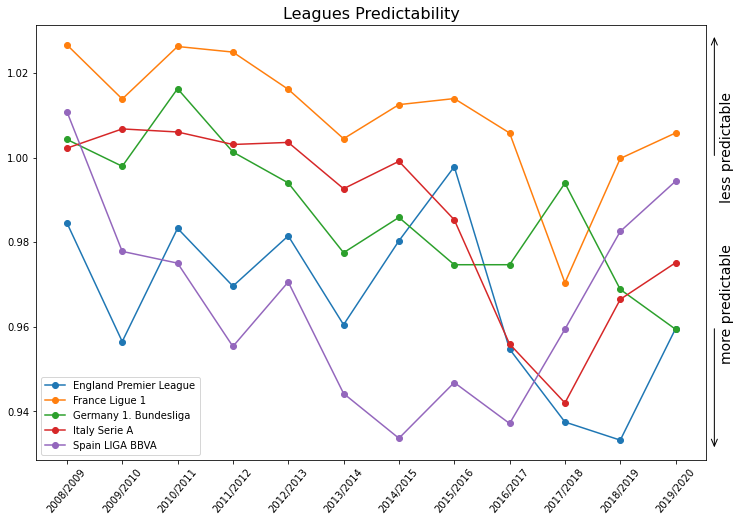

In [10]:
#plot graph
ax = entropy_means.plot(figsize=(12,8),marker='o')

#set title
plt.title('Leagues Predictability', fontsize=16)

num_seasons = len(matches.season.unique())

#set ticks frequency, labels and rotation
plt.xticks(np.arange(0, num_seasons, 1), matches.season.unique(), rotation=50)

#keep colors for next graph
colors = [x.get_color() for x in ax.get_lines()]
colors_mapping = dict(zip(matches.league_id.unique(),colors))

#remove x label
ax.set_xlabel('')

#locate legend
plt.legend(loc='lower left')

#add arrows
ax.annotate('', xytext=(11.7, 1),xy=(11.7, 1.029),
            arrowprops=dict(facecolor='black',arrowstyle="->, head_length=.7, head_width=.3",linewidth=1), annotation_clip=False)

ax.annotate('', xytext=(11.7, 0.96),xy=(11.7, 0.931),
            arrowprops=dict(facecolor='black',arrowstyle="->, head_length=.7, head_width=.3",linewidth=1), annotation_clip=False)

ax.annotate('less predictable', xy=(11.8, 0.99), annotation_clip=False,fontsize=14,rotation='vertical')
ax.annotate('more predictable', xy=(11.8, 0.952), annotation_clip=False,fontsize=14,rotation='vertical')

plt.savefig('../reports/figures/leagues_pred.png', bbox_inches='tight',dpi=600)

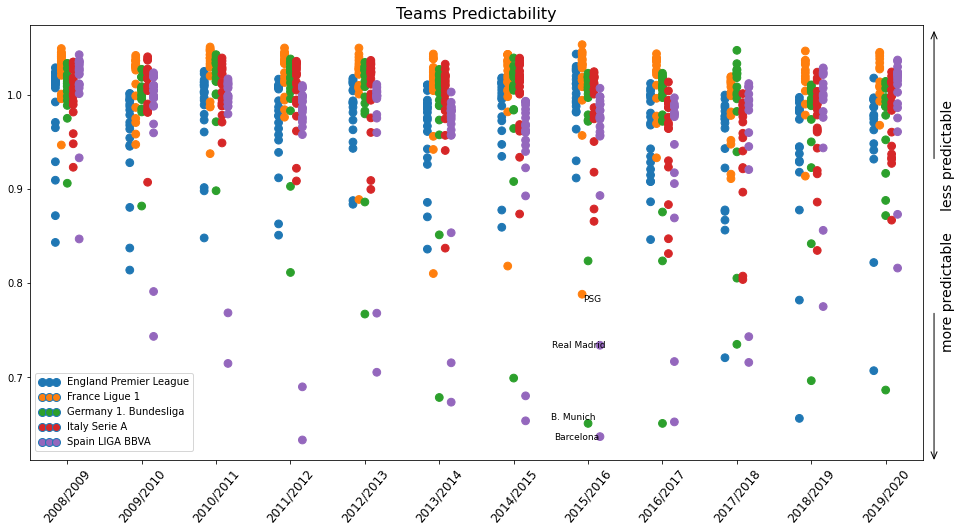

In [11]:
from matplotlib.lines import Line2D

offsets = [-0.16,-0.08,0,0.08,0.16]
offsets_mapping = dict(zip(colors_mapping.keys(),offsets))
y = []
x = []
c = []

i = -1
for season,season_df in matches.groupby('season'):
    i+=1
    for team,name in zip(teams.team_api_id,teams.team_long_name):
        team_df = season_df[(season_df.home_team_api_id==team)|(season_df.away_team_api_id==team)]
        team_entropy = team_df.entropy.mean()
        if team_entropy>0:
            league_id = team_df.league_id.values[0]
            x.append(i+offsets_mapping[league_id])
            y.append(team_entropy)
            c.append(colors_mapping[league_id])

plt.figure(figsize=(16,8))
plt.scatter(x,y,color=c,s=[60]*len(x))
plt.title('Teams Predictability', fontsize=16)

#create ticks and labels
ax = plt.gca()
plt.xlim((-0.5,num_seasons-0.5))
plt.xticks(np.arange(0,num_seasons,1),rotation=50)

#create grid
ax.set_xticklabels(entropy_means.index,fontsize=12)
for i in range(num_seasons-1):
    ax.axvline(x=0.5+i,ls='--',c='w')
ax.yaxis.grid(False)
ax.xaxis.grid(False)

#create legend
circles = []
labels = []
leagues = matches.groupby(['league_id','League']).count().reset_index()
for league_id,name in zip(leagues.league_id,leagues.League):
    labels.append(name)
    circles.append(Line2D([0], [0], linestyle="none", marker="o", markersize=8, markerfacecolor=colors_mapping[league_id]))
plt.legend(circles, labels, numpoints=3, loc=(0.005,0.02))


#add arrows
ax.annotate('', xytext=(11.65, 0.93),xy=(11.65, 1.07),
            arrowprops=dict(facecolor='black',arrowstyle="->, head_length=.7, head_width=.3",linewidth=1), annotation_clip=False)

ax.annotate('', xytext=(11.65, 0.77),xy=(11.65, 0.61),
            arrowprops=dict(facecolor='black',arrowstyle="->, head_length=.7, head_width=.3",linewidth=1), annotation_clip=False)

ax.annotate('less predictable', xy=(11.75, 0.88), annotation_clip=False,fontsize=14,rotation='vertical')
ax.annotate('more predictable', xy=(11.75, 0.73), annotation_clip=False,fontsize=14,rotation='vertical')

#add labels
ax.annotate('Barcelona', xy=(6.55, 0.634),fontsize=9)
ax.annotate('B. Munich', xy=(6.5, 0.655),fontsize=9)
ax.annotate('Real Madrid', xy=(6.51, 0.731),fontsize=9)
ax.annotate('PSG', xy=(6.93, 0.78),fontsize=9)

plt.savefig('../reports/figures/teams_pred.png', bbox_inches='tight',dpi=600)